In [1]:
import os, sys, time
import itertools
import imageio
import math
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
from dataset import get_data
from scipy.misc import imsave
import warnings
warnings.filterwarnings("ignore")

In [2]:
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.utils as utils
from torch.autograd import Variable
import torchvision.transforms as transforms
import torchvision.datasets as dset
import torchvision.utils as v_utils

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [4]:
class arguments():
    def __init__(self):
        self.dataset = 'CelebA'
        self.dataroot = '/data/jehyuk/imgdata'
        self.workers = 2
        self.n_gpu = 1
        self.batchsize = 32
        self.maxepoch = 10
        self.imagesize = 64
        self.lrG = 2e-5
        self.lrD = 2e-5
        self.channel_bunch = 64
        self.use_cuda = True
        self.n_z = 64
        self.result_dir = '/home/jehyuk/GenerativeModels/GAN/results/BEGAN/' + self.dataset
        self.save_dir = '/home/jehyuk/GenerativeModels/GAN/models/BEGAN' + self.dataset
        self.n_sample = 64

opt = arguments()

In [5]:
def load_dataset(dataroot = opt.dataroot, dataset=opt.dataset):
    data_folder = os.path.join(dataroot, dataset)
    if not os.path.exists(data_folder):
        os.makedirs(data_folder)
    transform = transforms.Compose([transforms.Scale(opt.imagesize),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])
    if dataset == 'MNIST':
        trn_data = dset.MNIST(data_folder, train=True, transform=transform, download=True)
        tst_data = dset.MNIST(data_folder, train=False, transform=transform, download=True)
        n_channels = 1
    elif dataset == 'Fashion-MNIST':
        trn_data = dset.FashionMNIST(data_folder, train=True, transform=transform, download=True)
        tst_data = dset.FashionMNIST(data_folder, train=False, transform=transform, download=True)
        n_channels = 1
    elif dataset == 'CIFAR10':
        trn_data = dset.cifar.CIFAR10(data_folder, train=True, transform=transform, download=True)
        tst_data = dset.cifar.CIFAR10(data_folder, train=False, transform=transform, download=True)
        n_channels = 3
    elif dataset == 'CelebA':
        trn_data = get_data(data_folder, split='train', image_size=opt.imagesize)
        tst_data = get_data(data_folder, split='test', image_size=opt.imagesize)
        n_channels = 3
    trn_loader = utils.data.DataLoader(trn_data, batch_size=opt.batchsize, shuffle=True, num_workers=opt.workers, drop_last=True)
    tst_loader = utils.data.DataLoader(tst_data, batch_size=opt.batchsize, shuffle=False, num_workers=opt.workers, drop_last=True)
    return trn_loader, tst_loader, n_channels

In [6]:
def initialize_weights(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
#         m.bias.data.zero_()
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

def print_network(net):
    num_params = 0
    for param in net.parameters():
        num_params += param.numel()
    print(net)
    print('Total number of parameters: %d' % num_params)

def save_images(images, size, image_path):
    image = np.squeeze(merge(images, size))
    return imsave(image_path, image)

def merge(images, size):
    h, w = images.shape[1], images.shape[2]
    if (images.shape[3] in (3,4)):
        c = images.shape[3]
        img = np.zeros((h * size[0], w * size[1], c))
        for idx, image in enumerate(images):
            i = idx % size[1]
            j = idx // size[1]
            img[j * h:j * h + h, i * w:i * w + w, :] = image
        return img
    elif images.shape[3]==1:
        img = np.zeros((h * size[0], w * size[1]))
        for idx, image in enumerate(images):
            i = idx % size[1]
            j = idx // size[1]
            img[j * h:j * h + h, i * w:i * w + w] = image[:,:,0]
        return img
    else:
        raise ValueError('in merge(images,size) images parameter ''must have dimensions: HxW or HxWx3 or HxWx4')


In [7]:
class Generator(nn.Module):
    def __init__(self, opt, n_channels):
        super(Generator, self).__init__()
        self.opt = opt
        self.n_channels = n_channels
        
        self.linear_layers = nn.Linear(self.opt.n_z, 8*8*self.opt.channel_bunch)
        
        layers = nn.Sequential()
        
        layers.add_module("Conv1-1", nn.Conv2d(self.opt.channel_bunch, self.opt.channel_bunch, kernel_size=3, stride=1, padding=1))
        layers.add_module("Activation1-1", nn.ELU(inplace=True))
        layers.add_module("Conv1-2", nn.Conv2d(self.opt.channel_bunch, self.opt.channel_bunch, kernel_size=3, stride=1, padding=1))
        layers.add_module("Activation1-2", nn.ELU(inplace=True))
        layers.add_module("Upsampling1", nn.Upsample(scale_factor=2))
        
        layers.add_module("Conv2-1", nn.Conv2d(self.opt.channel_bunch, self.opt.channel_bunch, kernel_size=3, stride=1, padding=1))
        layers.add_module("Activation2-1", nn.ELU(inplace=True))
        layers.add_module("Conv2-2", nn.Conv2d(self.opt.channel_bunch, self.opt.channel_bunch, kernel_size=3, stride=1, padding=1))
        layers.add_module("Activation2-2", nn.ELU(inplace=True))
        layers.add_module("Upsampling2", nn.Upsample(scale_factor=2))
        
        layers.add_module("Conv3-1", nn.Conv2d(self.opt.channel_bunch, self.opt.channel_bunch, kernel_size=3, stride=1, padding=1))
        layers.add_module("Activation3-1", nn.ELU(inplace=True))
        layers.add_module("Conv3-2", nn.Conv2d(self.opt.channel_bunch, self.opt.channel_bunch, kernel_size=3, stride=1, padding=1))
        layers.add_module("Activation3-2", nn.ELU(inplace=True))
        layers.add_module("Upsampling3", nn.Upsample(scale_factor=2))
        
        layers.add_module("Conv4-1", nn.Conv2d(self.opt.channel_bunch, self.opt.channel_bunch, kernel_size=3, stride=1, padding=1))
        layers.add_module("Activation4-1", nn.ELU(inplace=True))
        layers.add_module("Conv4-2", nn.Conv2d(self.opt.channel_bunch, self.opt.channel_bunch, kernel_size=3, stride=1, padding=1))
        layers.add_module("Activation4-2", nn.ELU(inplace=True))
        
        layers.add_module("Conv5", nn.Conv2d(self.opt.channel_bunch, self.n_channels, kernel_size=3, stride=1, padding=1))
#         layers.add_module("Activation4", nn.Sigmoid())
        
        self.layers = layers
        
    def forward(self, z):
        x = self.linear_layers(z)
        x = x.view(-1, self.opt.channel_bunch, 8, 8)
        x = self.layers(x)
        return x

In [8]:
class Decoder(nn.Module):
    def __init__(self, opt, n_channels):
        super(Decoder, self).__init__()
        self.opt = opt
        self.n_channels = n_channels
        
        self.linear_layers = nn.Linear(self.opt.n_z, 8*8*self.opt.channel_bunch)
        
        layers = nn.Sequential()
        
        layers.add_module("Conv1-1", nn.Conv2d(self.opt.channel_bunch, self.opt.channel_bunch, kernel_size=3, stride=1, padding=1))
        layers.add_module("Activation1-1", nn.ELU(inplace=True))
        layers.add_module("Conv1-2", nn.Conv2d(self.opt.channel_bunch, self.opt.channel_bunch, kernel_size=3, stride=1, padding=1))
        layers.add_module("Activation1-2", nn.ELU(inplace=True))
        layers.add_module("Upsampling1", nn.Upsample(scale_factor=2))
        
        layers.add_module("Conv2-1", nn.Conv2d(self.opt.channel_bunch, self.opt.channel_bunch, kernel_size=3, stride=1, padding=1))
        layers.add_module("Activation2-1", nn.ELU(inplace=True))
        layers.add_module("Conv2-2", nn.Conv2d(self.opt.channel_bunch, self.opt.channel_bunch, kernel_size=3, stride=1, padding=1))
        layers.add_module("Activation2-2", nn.ELU(inplace=True))
        layers.add_module("Upsampling2", nn.Upsample(scale_factor=2))
        
        layers.add_module("Conv3-1", nn.Conv2d(self.opt.channel_bunch, self.opt.channel_bunch, kernel_size=3, stride=1, padding=1))
        layers.add_module("Activation3-1", nn.ELU(inplace=True))
        layers.add_module("Conv3-2", nn.Conv2d(self.opt.channel_bunch, self.opt.channel_bunch, kernel_size=3, stride=1, padding=1))
        layers.add_module("Activation3-2", nn.ELU(inplace=True))
        layers.add_module("Upsampling3", nn.Upsample(scale_factor=2))
        
        layers.add_module("Conv4-1", nn.Conv2d(self.opt.channel_bunch, self.opt.channel_bunch, kernel_size=3, stride=1, padding=1))
        layers.add_module("Activation4-1", nn.ELU(inplace=True))
        layers.add_module("Conv4-2", nn.Conv2d(self.opt.channel_bunch, self.opt.channel_bunch, kernel_size=3, stride=1, padding=1))
        layers.add_module("Activation4-2", nn.ELU(inplace=True))
        
        layers.add_module("Conv5", nn.Conv2d(self.opt.channel_bunch, self.n_channels, kernel_size=3, stride=1, padding=1))
#         layers.add_module("Activation4", nn.Sigmoid())
        
        self.layers = layers
        
    def forward(self, z):
        x = self.linear_layers(z)
        x = x.view(-1, self.opt.channel_bunch, 8, 8)
        x = self.layers(x)
        return x

In [9]:
class Encoder(nn.Module):
    def __init__(self, opt, n_channels):
        super(Encoder, self).__init__()
        self.opt = opt
        self.n_channels = n_channels
        
        layers = nn.Sequential()
        layers.add_module("Conv0", nn.Conv2d(self.n_channels, self.opt.channel_bunch, kernel_size=3, stride=1, padding=1))
        
        layers.add_module("Conv1-1", nn.Conv2d(self.opt.channel_bunch, self.opt.channel_bunch, kernel_size=3, stride=1, padding=1))
        layers.add_module("Activation1-1", nn.ELU(inplace=True))
        layers.add_module("Conv1-2", nn.Conv2d(self.opt.channel_bunch, self.opt.channel_bunch, kernel_size=3, stride=1, padding=1))
        layers.add_module("Activation1-2", nn.ELU(inplace=True))
        layers.add_module("Subsampling1", nn.Conv2d(self.opt.channel_bunch, self.opt.channel_bunch, kernel_size=3, stride=2, padding=1))
        layers.add_module("Activation1-3", nn.ELU(inplace=True))
        
        layers.add_module("Conv2-1", nn.Conv2d(self.opt.channel_bunch, self.opt.channel_bunch*2, kernel_size=3, stride=1, padding=1))
        layers.add_module("Activation2-1", nn.ELU(inplace=True))
        layers.add_module("Conv2-2", nn.Conv2d(self.opt.channel_bunch*2, self.opt.channel_bunch*2, kernel_size=3, stride=1, padding=1))
        layers.add_module("Activation2-2", nn.ELU(inplace=True))
        layers.add_module("Subsampling2", nn.Conv2d(self.opt.channel_bunch*2, self.opt.channel_bunch*2, kernel_size=3, stride=2, padding=1))
        layers.add_module("Activation2-3", nn.ELU(inplace=True))
        
        layers.add_module("Conv3-1", nn.Conv2d(self.opt.channel_bunch*2, self.opt.channel_bunch*3, kernel_size=3, stride=1, padding=1))
        layers.add_module("Activation3-1", nn.ELU(inplace=True))
        layers.add_module("Conv3-2", nn.Conv2d(self.opt.channel_bunch*3, self.opt.channel_bunch*3, kernel_size=3, stride=1, padding=1))
        layers.add_module("Activation3-2", nn.ELU(inplace=True))
        layers.add_module("Subsampling3", nn.Conv2d(self.opt.channel_bunch*3, self.opt.channel_bunch*3, kernel_size=3, stride=2, padding=1))
        layers.add_module("Activation3-3", nn.ELU(inplace=True))
        
        layers.add_module("Conv4-1", nn.Conv2d(self.opt.channel_bunch*3, self.opt.channel_bunch*4, kernel_size=3, stride=1, padding=1))
        layers.add_module("Activation4-1", nn.ELU(inplace=True))
        layers.add_module("Conv4-2", nn.Conv2d(self.opt.channel_bunch*4, self.opt.channel_bunch*4, kernel_size=3, stride=1, padding=1))
        layers.add_module("Activation4-2", nn.ELU(inplace=True))

        self.layers = layers
        self.linear_layers = nn.Linear(8*8*self.opt.channel_bunch*4, self.opt.n_z)
    
    def forward(self, x):
        x = self.layers(x)
        x = x.view(-1, 8*8*self.opt.channel_bunch*4)
        z = self.linear_layers(x)
        return z

In [10]:
# class Encoder(nn.Module):
#     def __init__(self, opt, n_channels):
#         super(Encoder, self).__init__()
#         self.opt = opt
#         self.n_channels = n_channels
        
#         layers = nn.Sequential()
#         layers.add_module("Conv0", nn.Conv2d(self.n_channels, self.opt.channel_bunch, kernel_size=3, stride=1, padding=1))
        
#         layers.add_module("Conv1-1", nn.Conv2d(self.opt.channel_bunch, self.opt.channel_bunch, kernel_size=3, stride=1, padding=1))
#         layers.add_module("Activation1-1", nn.ELU(inplace=True))
#         layers.add_module("Conv1-2", nn.Conv2d(self.opt.channel_bunch, self.opt.channel_bunch*2, kernel_size=3, stride=1, padding=1))
#         layers.add_module("Activation1-2", nn.ELU(inplace=True))
#         layers.add_module("Subsampling1", nn.AvgPool2d(kernel_size=2, stride=2))
        
#         layers.add_module("Conv2-1", nn.Conv2d(self.opt.channel_bunch*2, self.opt.channel_bunch*2, kernel_size=3, stride=1, padding=1))
#         layers.add_module("Activation2-1", nn.ELU(inplace=True))
#         layers.add_module("Conv2-2", nn.Conv2d(self.opt.channel_bunch*2, self.opt.channel_bunch*3, kernel_size=3, stride=1, padding=1))
#         layers.add_module("Activation2-2", nn.ELU(inplace=True))
#         layers.add_module("Subsampling2", nn.AvgPool2d(kernel_size=2, stride=2))
        
#         layers.add_module("Conv3-1", nn.Conv2d(self.opt.channel_bunch*3, self.opt.channel_bunch*3, kernel_size=3, stride=1, padding=1))
#         layers.add_module("Activation3-1", nn.ELU(inplace=True))
#         layers.add_module("Conv3-2", nn.Conv2d(self.opt.channel_bunch*3, self.opt.channel_bunch*3, kernel_size=3, stride=1, padding=1))

#         self.layers = layers
#         self.linear_layers = nn.Linear(8*8*self.opt.channel_bunch*3, self.opt.n_z)
    
#     def forward(self, x):
#         x = self.layers(x)
#         x = x.view(-1, 8*8*self.opt.channel_bunch*3)
#         z = self.linear_layers(x)
#         return z

In [11]:
class Discriminator(nn.Module):
    def __init__(self, opt, n_channels):
        super(Discriminator, self).__init__()
        self.encoder = Encoder(opt, n_channels)
        self.decoder = Decoder(opt, n_channels)
    def forward(self, x):
        z = self.encoder.forward(x)
        x_hat = self.decoder.forward(z)
        return x_hat

In [12]:
class BEGAN(object):
    def __init__(self, opt):
        self.opt = opt
        self.trn_loader, self.tst_loader, self.n_channels = load_dataset(self.opt.dataroot, self.opt.dataset)
        self.is_cuda = torch.cuda.is_available()
        self.gamma = 0.35
        self.lambda_ = 0.001
        self.k = 0.0
        
        self.G = Generator(self.opt, self.n_channels)
        self.D = Discriminator(self.opt, self.n_channels)
        self.G.apply(initialize_weights)
        self.D.apply(initialize_weights)
        self.sample_z = Variable(torch.randn((self.opt.n_sample, self.opt.n_z)), volatile=True)
                
        if self.is_cuda and self.opt.use_cuda:
            self.G, self.D = self.G.cuda(), self.D.cuda()
            self.sample_z = self.sample_z.cuda()
        
        self.optim_G = torch.optim.Adam(self.G.parameters(), lr = self.opt.lrG, betas=(0.5,0.999))
        self.optim_D = torch.optim.Adam(self.D.parameters(), lr = self.opt.lrD, betas=(0.5,0.999))
        
    def train(self):
        self.loss_dict=dict()
        self.loss_dict['G_loss'], self.loss_dict['D_loss'] = list(), list()
        self.loss_dict['conv_measure'] = list()
        
        
        self.D.train()
        print('------------------Start training------------------')
        for epoch in range(self.opt.maxepoch):
            self.G.train()
            print(">>>>Epoch: {}".format(epoch+1))
            start_time = time.time()
            for iter_num, (image, label) in enumerate(self.trn_loader):
                x = Variable(image)
                z1 = Variable(torch.randn(self.opt.batchsize, self.opt.n_z))
                z2 = Variable(torch.randn(self.opt.batchsize, self.opt.n_z))
                if self.is_cuda:
                    x, z1, z2 = x.cuda(), z1.cuda(), z2.cuda()
                
                # Train D
                self.D.zero_grad()
                D_x = self.D.forward(x)
                L_x = torch.mean(torch.abs(x - D_x))
                
                G_z = self.G.forward(z1)
                D_G_z = self.D.forward(G_z)
                L_Gz = torch.mean(torch.abs(G_z - D_G_z))
                
                D_loss = L_x - self.k * L_Gz
                self.loss_dict['D_loss'].append(D_loss.data[0])
                D_loss.backward()
                self.optim_D.step()
                
                #Train G
                self.G.zero_grad()
                G_z = self.G.forward(z2)
                D_G_z = self.D.forward(G_z)
                L_Gz = torch.mean(torch.abs(G_z - D_G_z))
                G_loss = L_Gz
                
                self.loss_dict['G_loss'].append(G_loss.data[0])
                G_loss.backward()
                self.optim_G.step()
                
                #Convergence Metric(M)
                M = L_x + torch.abs(self.gamma * L_x - L_Gz)
                
                # Update k
                tmp_k = self.k + self.lambda_ * (self.gamma*L_x - L_Gz)
                tmp_k = tmp_k.data[0]
                
                self.k = min(max(tmp_k, 0), 1) # To make 0<=k<=1
                self.M = M.data[0]
                self.loss_dict['conv_measure'].append(M.data[0])

                if (iter_num+1) % 500 == 0:
                    print("Epoch: {}, iter: {}, D_loss: {:.3f}, G_loss: {:.3f}, M: {:.3f}".format(epoch+1, iter_num+1, D_loss.data[0], G_loss.data[0], M.data[0]))
            print(">>>>Time for 1 epoch: {:.2f}".format(time.time()-start_time))
            self.save_results(epoch+1, self.sample_z)
        self.save_model()
            
    def save_results(self, epoch, sample):
        self.G.eval()
        if not os.path.exists(self.opt.result_dir):
            os.makedirs(self.opt.result_dir)
        fake_file_name = self.opt.result_dir + '/BEGAN_epoch%03d' %epoch + '.png'
        fake_results = self.G.forward(sample)
        v_utils.save_image(fake_results.data, fake_file_name, nrow = int(math.sqrt(self.opt.n_sample)), normalize=True)
    
#     def visualize_results(self, epoch, _iter, fix=True):
#         self.G.eval()
#         if not os.path.exists(self.opt.result_dir):
#             os.makedirs(self.opt.result_dir)
#         image_frame_dim = int(np.floor(np.sqrt(self.opt.n_sample)))
        
#         if fix:
#             G_z_sample = self.G(self.sample_z)
#         else:
#             sample_z = Variable(torch.randn((self.opt.n_sample, self.opt.n_z)), volatile=True)
#             if self.is_cuda and self.opt.use_cuda:
#                 sample_z = sample_z.cuda()
#             G_z_sample = self.G(sample_z)

#         if self.is_cuda and self.opt.use_cuda:
#             G_z_sample = G_z_sample.cpu().data.numpy().transpose(0,2,3,1)
#         else:
#             G_z_sample = G_z_sample.data.numpy().transpose(0,2,3,1)

#         save_images(G_z_sample[:image_frame_dim * image_frame_dim,:,:,:], [image_frame_dim, image_frame_dim], self.opt.result_dir + '/' + 'BEGAN_epoch%03d_iter%04d' %(epoch, _iter)  + '.png')
        
    def save_model(self):
        if not os.path.exists(self.opt.save_dir):
            os.makedirs(self.opt.save_dir)
        torch.save(self.G.state_dict(), os.path.join(self.opt.save_dir, 'G.pkl'))
        torch.save(self.D.state_dict(), os.path.join(self.opt.save_dir, 'D.pkl'))
        with open(os.path.join(self.opt.save_dir, 'loss_dict'), 'wb') as f:
            pickle.dump(self.loss_dict, f)
    
    def load_model(self):
        self.G.load_state_dict(torch.load(os.path.join(self.opt.save_dir, 'G.pkl')))
        self.D.load_state_dict(torch.load(os.path.join(self.opt.save_dir, 'D.pkl')))

In [13]:
began = BEGAN(opt)
began.train()

Found 162770 images in subfolders of: /data/jehyuk/imgdata/CelebA/splits/train
Found 19962 images in subfolders of: /data/jehyuk/imgdata/CelebA/splits/test
------------------Start training------------------
>>>>Epoch: 1
Epoch: 1, iter: 500, D_loss: 0.128, G_loss: 0.016, M: 0.157
Epoch: 1, iter: 1000, D_loss: 0.122, G_loss: 0.025, M: 0.141
Epoch: 1, iter: 1500, D_loss: 0.102, G_loss: 0.041, M: 0.107
Epoch: 1, iter: 2000, D_loss: 0.106, G_loss: 0.033, M: 0.111
Epoch: 1, iter: 2500, D_loss: 0.110, G_loss: 0.035, M: 0.114
Epoch: 1, iter: 3000, D_loss: 0.094, G_loss: 0.032, M: 0.096
Epoch: 1, iter: 3500, D_loss: 0.096, G_loss: 0.024, M: 0.106
Epoch: 1, iter: 4000, D_loss: 0.098, G_loss: 0.026, M: 0.107
Epoch: 1, iter: 4500, D_loss: 0.096, G_loss: 0.023, M: 0.108
Epoch: 1, iter: 5000, D_loss: 0.094, G_loss: 0.020, M: 0.108
>>>>Time for 1 epoch: 773.43
>>>>Epoch: 2
Epoch: 2, iter: 500, D_loss: 0.079, G_loss: 0.022, M: 0.085
Epoch: 2, iter: 1000, D_loss: 0.084, G_loss: 0.026, M: 0.088
Epoch: 2

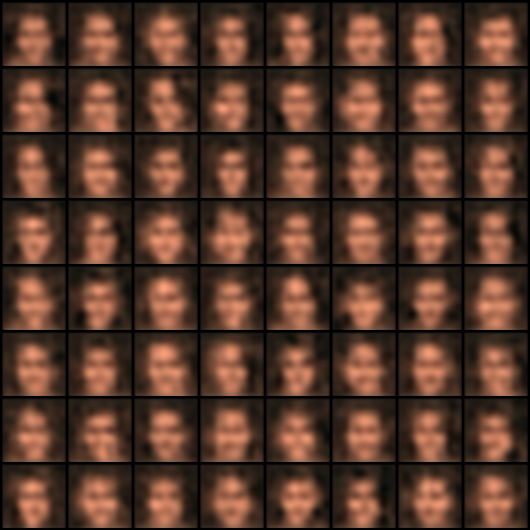

In [14]:
from IPython.display import Image
Image("/home/jehyuk/GenerativeModels/GAN/results/BEGAN/CelebA/BEGAN_epoch001.png", width = 256, height=256)

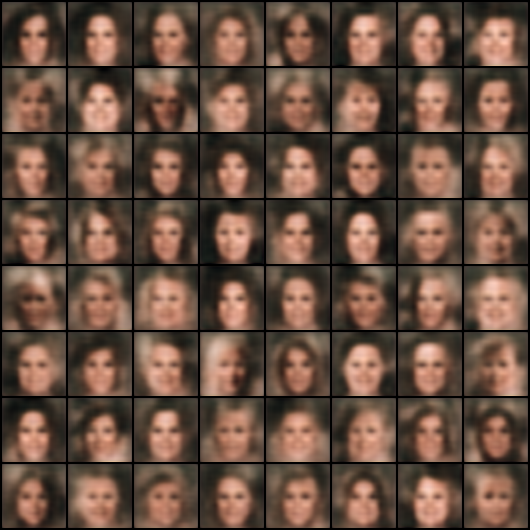

In [15]:
Image("/home/jehyuk/GenerativeModels/GAN/results/BEGAN/CelebA/BEGAN_epoch002.png", width = 256, height=256)

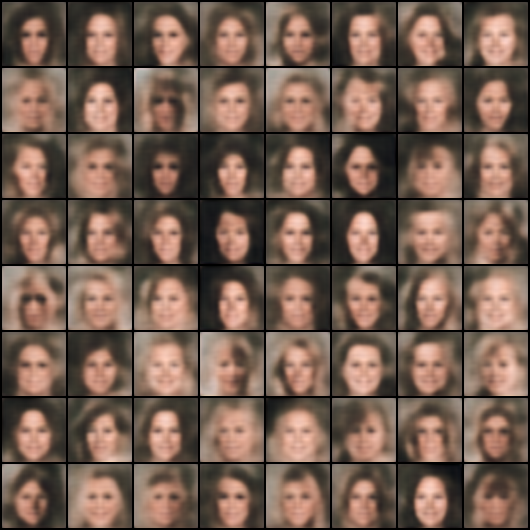

In [16]:
Image("/home/jehyuk/GenerativeModels/GAN/results/BEGAN/CelebA/BEGAN_epoch003.png", width = 256, height=256)

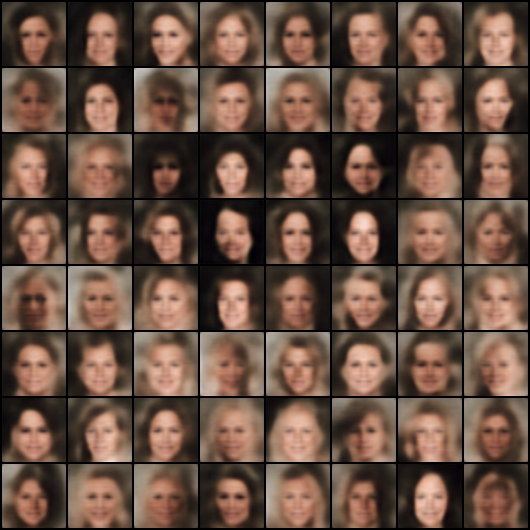

In [17]:
Image("/home/jehyuk/GenerativeModels/GAN/results/BEGAN/CelebA/BEGAN_epoch004.png", width = 256, height=256)

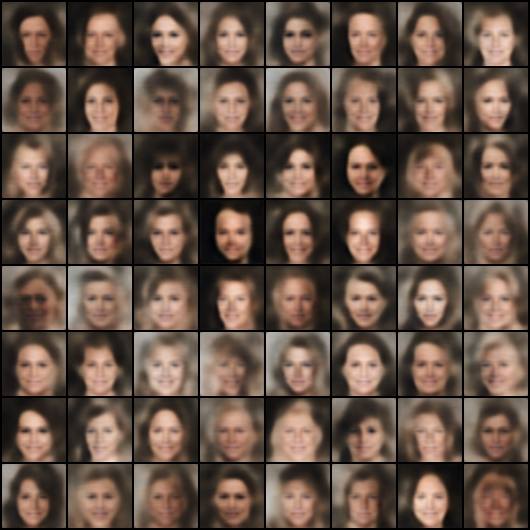

In [18]:
Image("/home/jehyuk/GenerativeModels/GAN/results/BEGAN/CelebA/BEGAN_epoch005.png", width = 256, height=256)

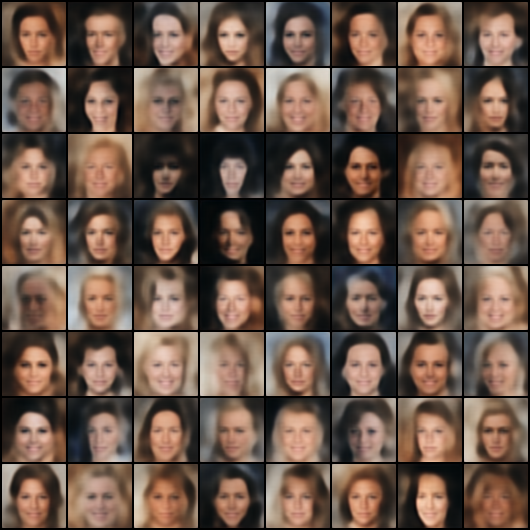

In [25]:
Image("/home/jehyuk/GenerativeModels/GAN/results/BEGAN/CelebA/BEGAN_epoch010.png", width = 512, height=512)

In [20]:
# from torchvision.transforms import ToPILImage

In [21]:


# r_sample = Variable(torch.rand((began.opt.n_sample, began.opt.n_z)), volatile=True).cuda()
# # began.G.eval()
# result = began.G.forward(r_sample)
# img_pil = ToPILImage()(result.squeeze().cpu().data)

# # type(result.cpu().data)

# # # display tensor
# # a = t.Tensor(3, 64, 64).normal_()
# # to_img(a)
